# Title

# ToC

# Introduction 

In [63]:
import sys

sys.path.append("./preprocessing")
sys.path.append("./analysis")
sys.path.append("./nlp")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import ast 
from wordcloud import WordCloud

# Our tools (see python files in preprocessing and analysis)
import loader
import cleaner
import merger
import visualizer as viz
import nlp_utils as nlputils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Pre-processing

In this section we perform loading and cleaning of our dataset

## 1.1. Loading and basic cleaning

### Part 1: CMU dataset

After loading these two datasets, we perfom some cleaning on the movies: 

- We convert string date to real datetime python object.
- We drop rows with no release date.

In [7]:
# Loading 
character_df, movie_df = loader.load_CMU_dataset()
summaries_df = loader.load_summaries()

# Basic cleaning
movie_df = cleaner.clean_movie_df(movie_df)

### Part 2: TMDB Dataset

Here we load the TMDB Dataset. We noticed that often gender are missing while names are available, We used wikipedia to recover gender based on names. We alos used the `GenderGuesser` Python package that allows to fill most of missing values for directors and procuders.

In [5]:
# Loading
credits_df, meta_df = loader.load_tmdb_dataset()

# Basic cleaning (scraping takes times)
credits_df = cleaner.clean_credit_df(credits_df, meta_df)
meta_df = cleaner.clean_metadata_df(meta_df)

Before using wikipedia and genderguesser:
Percentage of movies with a director's name that could not be gendered: 39.44%
Percentage of movies with a producer's name that could not be gendered: 70.92%
Percentage of movies with a writer's name that could not be gendered:   77.54%

After using genderguesser:
Percentage of movies with a director's name that could not be gendered: 6.55%
Percentage of movies with a producer's name that could not be gendered: 54.08%
Percentage of movies with a writer's name that could not be gendered:   57.74%

After using wikipedia:
Percentage of movies with a director's name that could not be gendered: 1.95%
Percentage of movies with a producer's name that could not be gendered: 30.73%
Percentage of movies with a writer's name that could not be gendered:   57.7%


### Part 3: Bechdel Dataset 

In the cleaning process, we drop the column `id` which is not useful for our analysis. 

In [8]:
# Loading
bechdel_df = loader.load_bechdel_dataset()

# Basic cleaning
bechdel_df = cleaner.clean_bechdel_df(bechdel_df)

## 1.2. Putting all together

This section merge all of our loaded and pre-processed dataset to make only one big `movies` dataframe that will be used through the entire analysis. 

In [9]:
# Merge datasets
movies = merger.merge_with_char(movie_df, character_df)
movies = merger.merge_with_summaries(movies, summaries_df)
movies = merger.merge_with_metadata(movies, meta_df)
movies = merger.merge_with_credits(movies, credits_df)

# Put the actor_name column at the beginning since we have one row per actor name
movies = movies.reindex(
    columns=["actor_name"] + [col for col in movies.columns if col != "actor_name"]
)

display(movies.sample(5))

# It will be useful when we will analyze the effect of the bechdel score rating on
# the women's representation in movies
movies_with_bechdel = merger.merge_with_bechdel(movies, bechdel_df)

,actor_name,wikiID,freebaseID,movie_title,movie_release_date,movie_bo_revenue,movie_runtime,fbid_languages,fbid_countries,fbid_genres,...,popularity,vote_average,imdbid,id,director,director_gender,producer,producer_gender,writer,writer_gender
152028,Jean-Pierre Léaud,914479,/m/03pg8g,Antoine and Colette,1962-07-01,NaN,32.0,[French Language],[France],"[Short Film, Black-and-white]",...,1.673854,7.1,1180329,256,Brett Harvey,M,NaN,NaN,NaN,NaN
7915,Brie Larson,3934285,/m/0b7hdh,Hoot,2006-05-05,8224998.0,95.0,[English Language],[United States of America],"[Adventure, Children's/Family, Coming of age, ...",...,6.429619,5.5,0453494,18276,Wil Shriner,M,Frank Marshall,M,NaN,NaN
159008,Rachel Weisz,1571097,/m/05c9zr,Eragon,2006-12-13,249488115.0,99.0,[English Language],"[United States of America, Australia, Hungary,...","[Fantasy Adventure, Adventure, Costume drama, ...",...,9.851133,4.9,0449010,2486,Stefen Fangmeier,NaN,John Davis,M,NaN,NaN
49361,George Buck,1338461,/m/04txpl,Birdy,1984-12-14,1455045.0,120.0,[English Language],[United States of America],"[Drama, Period piece, Film adaptation, Coming ...",...,16.243093,6.9,0086969,11296,Alan Parker,M,Alan Marshall,M,NaN,NaN
79362,Kyle Eastwood,5016299,/m/0czy__,Honkytonk Man,1982-12-15,NaN,123.0,[English Language],[United States of America],"[Road movie, Musical, Drama, Comedy, Musical D...",...,3.793634,5.4,0084088,37917,Clint Eastwood,M,Clint Eastwood,M,NaN,NaN


In [34]:
# Alternatively:
# You can directly load full cleaned and merged data
movies = pd.read_pickle("./data/Processed/movies_cleaned.pkl")
movies_with_bechdel = pd.read_pickle("./data/Processed/movies_with_bechdel.pkl")

## 1.3. Advanced Cleaning and Pre-processing

This section is devoted to a more in-depth cleaning of our big dataset `movies`.

### Part 1. Outlier Removal 

In [10]:
movies.drop(columns=["wikiID"]).describe()

,movie_bo_revenue,movie_runtime,year,actor_height_meters,actor_age_at_movie_release,vote_average
count,8.174700e+04,167861.000000,170127.000000,77404.000000,125455.000000,170127.000000
mean,7.591529e+07,105.253108,1988.899410,1.785753,38.336384,6.029420
std,1.491195e+08,26.051526,21.754745,3.765668,14.353359,1.220987
min,1.047400e+04,0.566667,1893.000000,0.610000,-81.000000,0.000000
25%,5.781045e+06,91.000000,1977.000000,1.680000,28.000000,5.500000
50%,2.257359e+07,101.000000,1997.000000,1.760000,37.000000,6.200000
75%,7.837120e+07,115.000000,2006.000000,1.830000,47.000000,6.800000
max,2.782275e+09,1003.000000,2014.000000,510.000000,96.000000,10.000000


As one can see, there are outliers and dirty samples in the data: negative actor's ages, movies of 16h long, etc.
We will remove them in the next cell, outliers will be remove by quantile method (see [here](./preprocessing/cleaner.py#clean_remove_outlier))

In [11]:
movies = cleaner.clean_movies_ranges(movies)
movies = cleaner.clean_remove_outlier(
    movies, method="quantile", name="actor_height_meters"
)
movies = cleaner.clean_remove_outlier(movies, method="quantile", name="movie_runtime")

movies.drop(columns=["wikiID"]).describe()

,movie_bo_revenue,movie_runtime,year,actor_height_meters,actor_age_at_movie_release,vote_average
count,4.254300e+04,71601.000000,71601.000000,71601.000000,67696.000000,71601.000000
mean,7.767795e+07,103.272821,1991.414394,1.756210,37.778658,5.959284
std,1.334172e+08,15.544283,19.578993,0.100157,13.744698,1.133186
min,1.263600e+04,60.000000,1914.000000,1.470000,0.000000,0.000000
25%,7.175592e+06,92.000000,1984.000000,1.680000,28.000000,5.500000
50%,2.696019e+07,101.000000,1998.000000,1.760000,36.000000,6.100000
75%,8.832349e+07,113.000000,2006.000000,1.830000,46.000000,6.700000
max,1.511758e+09,148.000000,2012.000000,2.050000,95.000000,10.000000


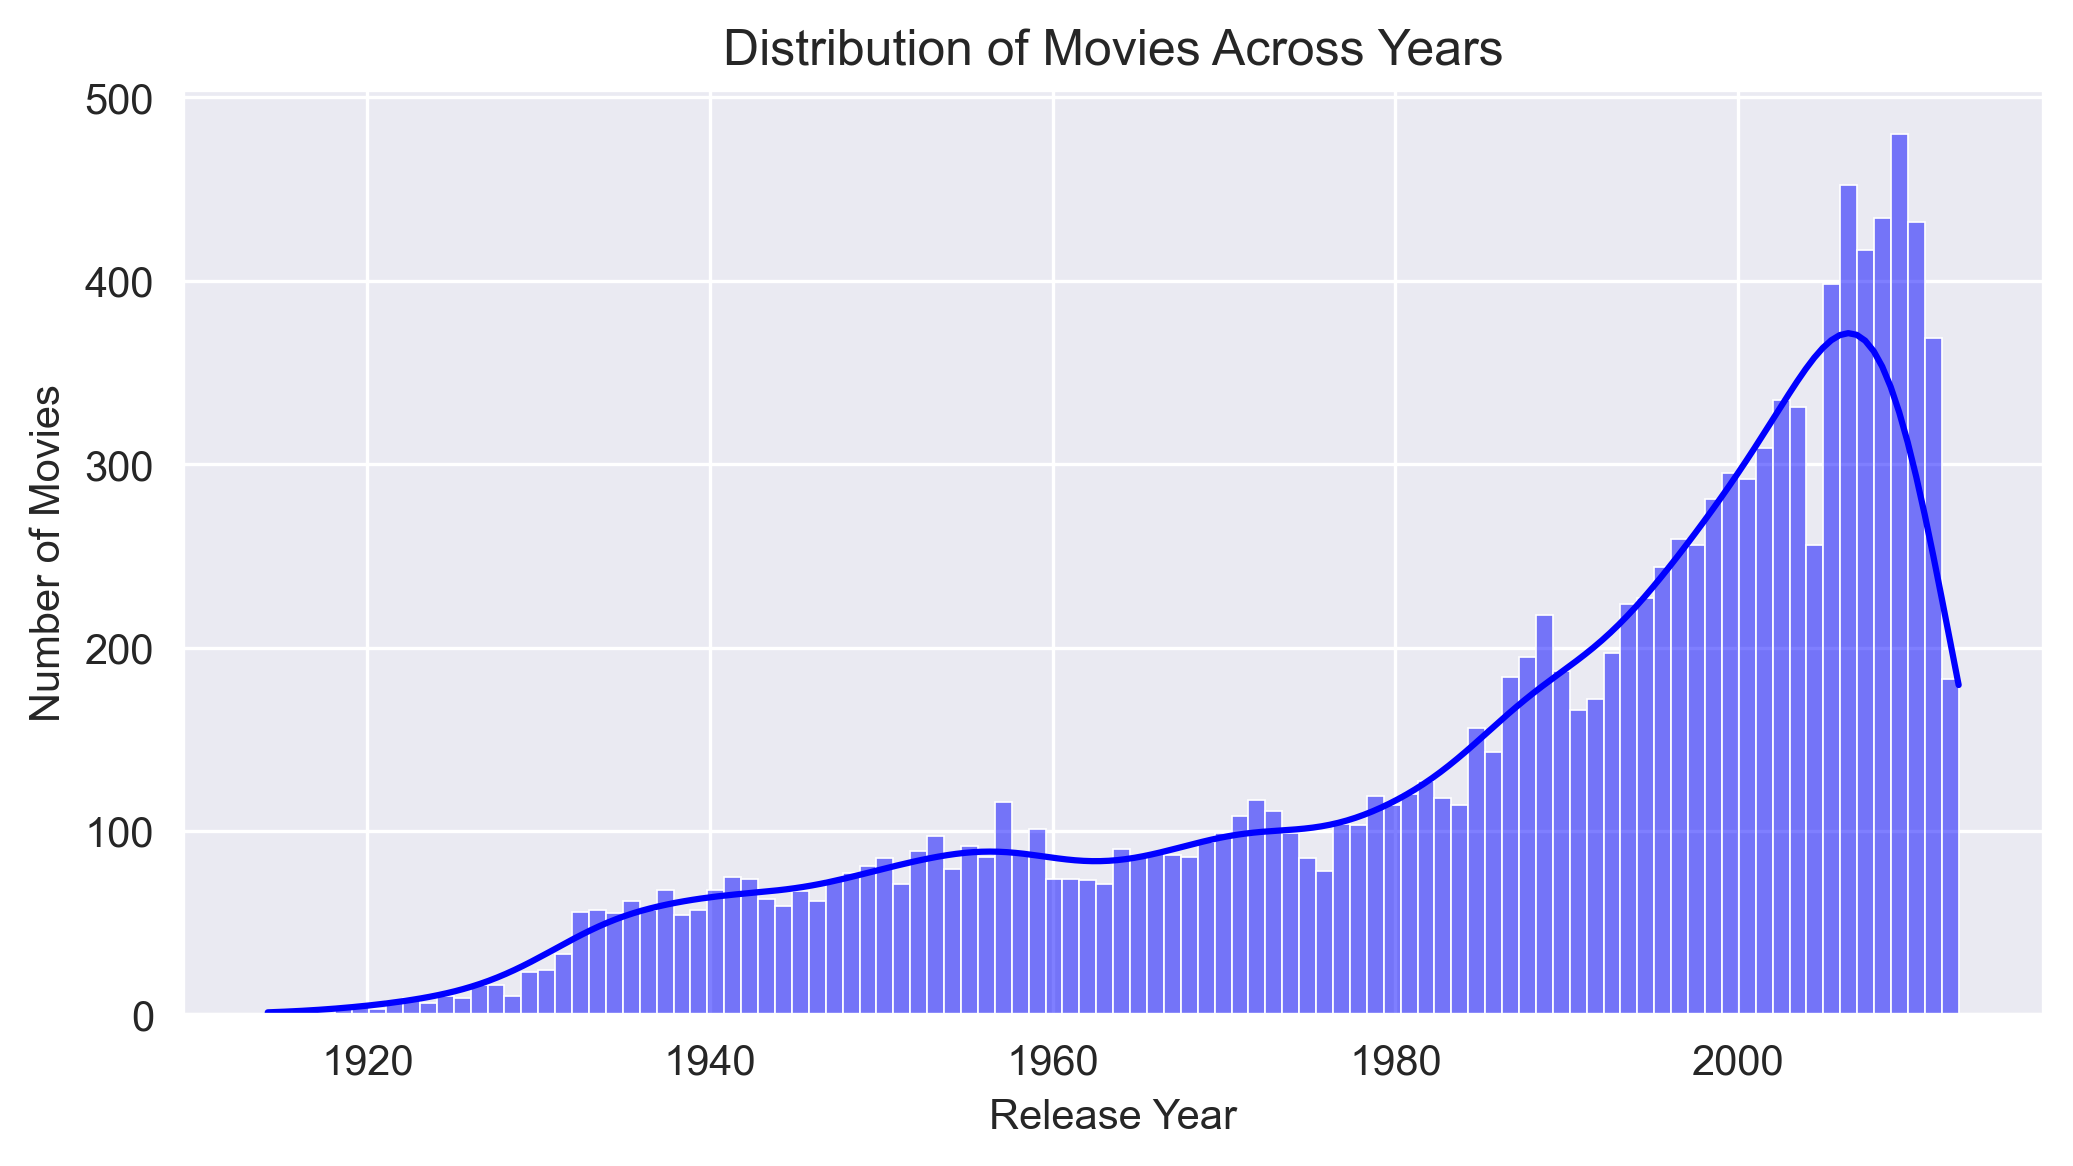

Total number of movies:  12779
Mean number of movies per year: 132


In [12]:
viz.visualize_year_distribution(movies)

### Part 2. Handling missing values

Here, we interested in the proportion of missing values. 

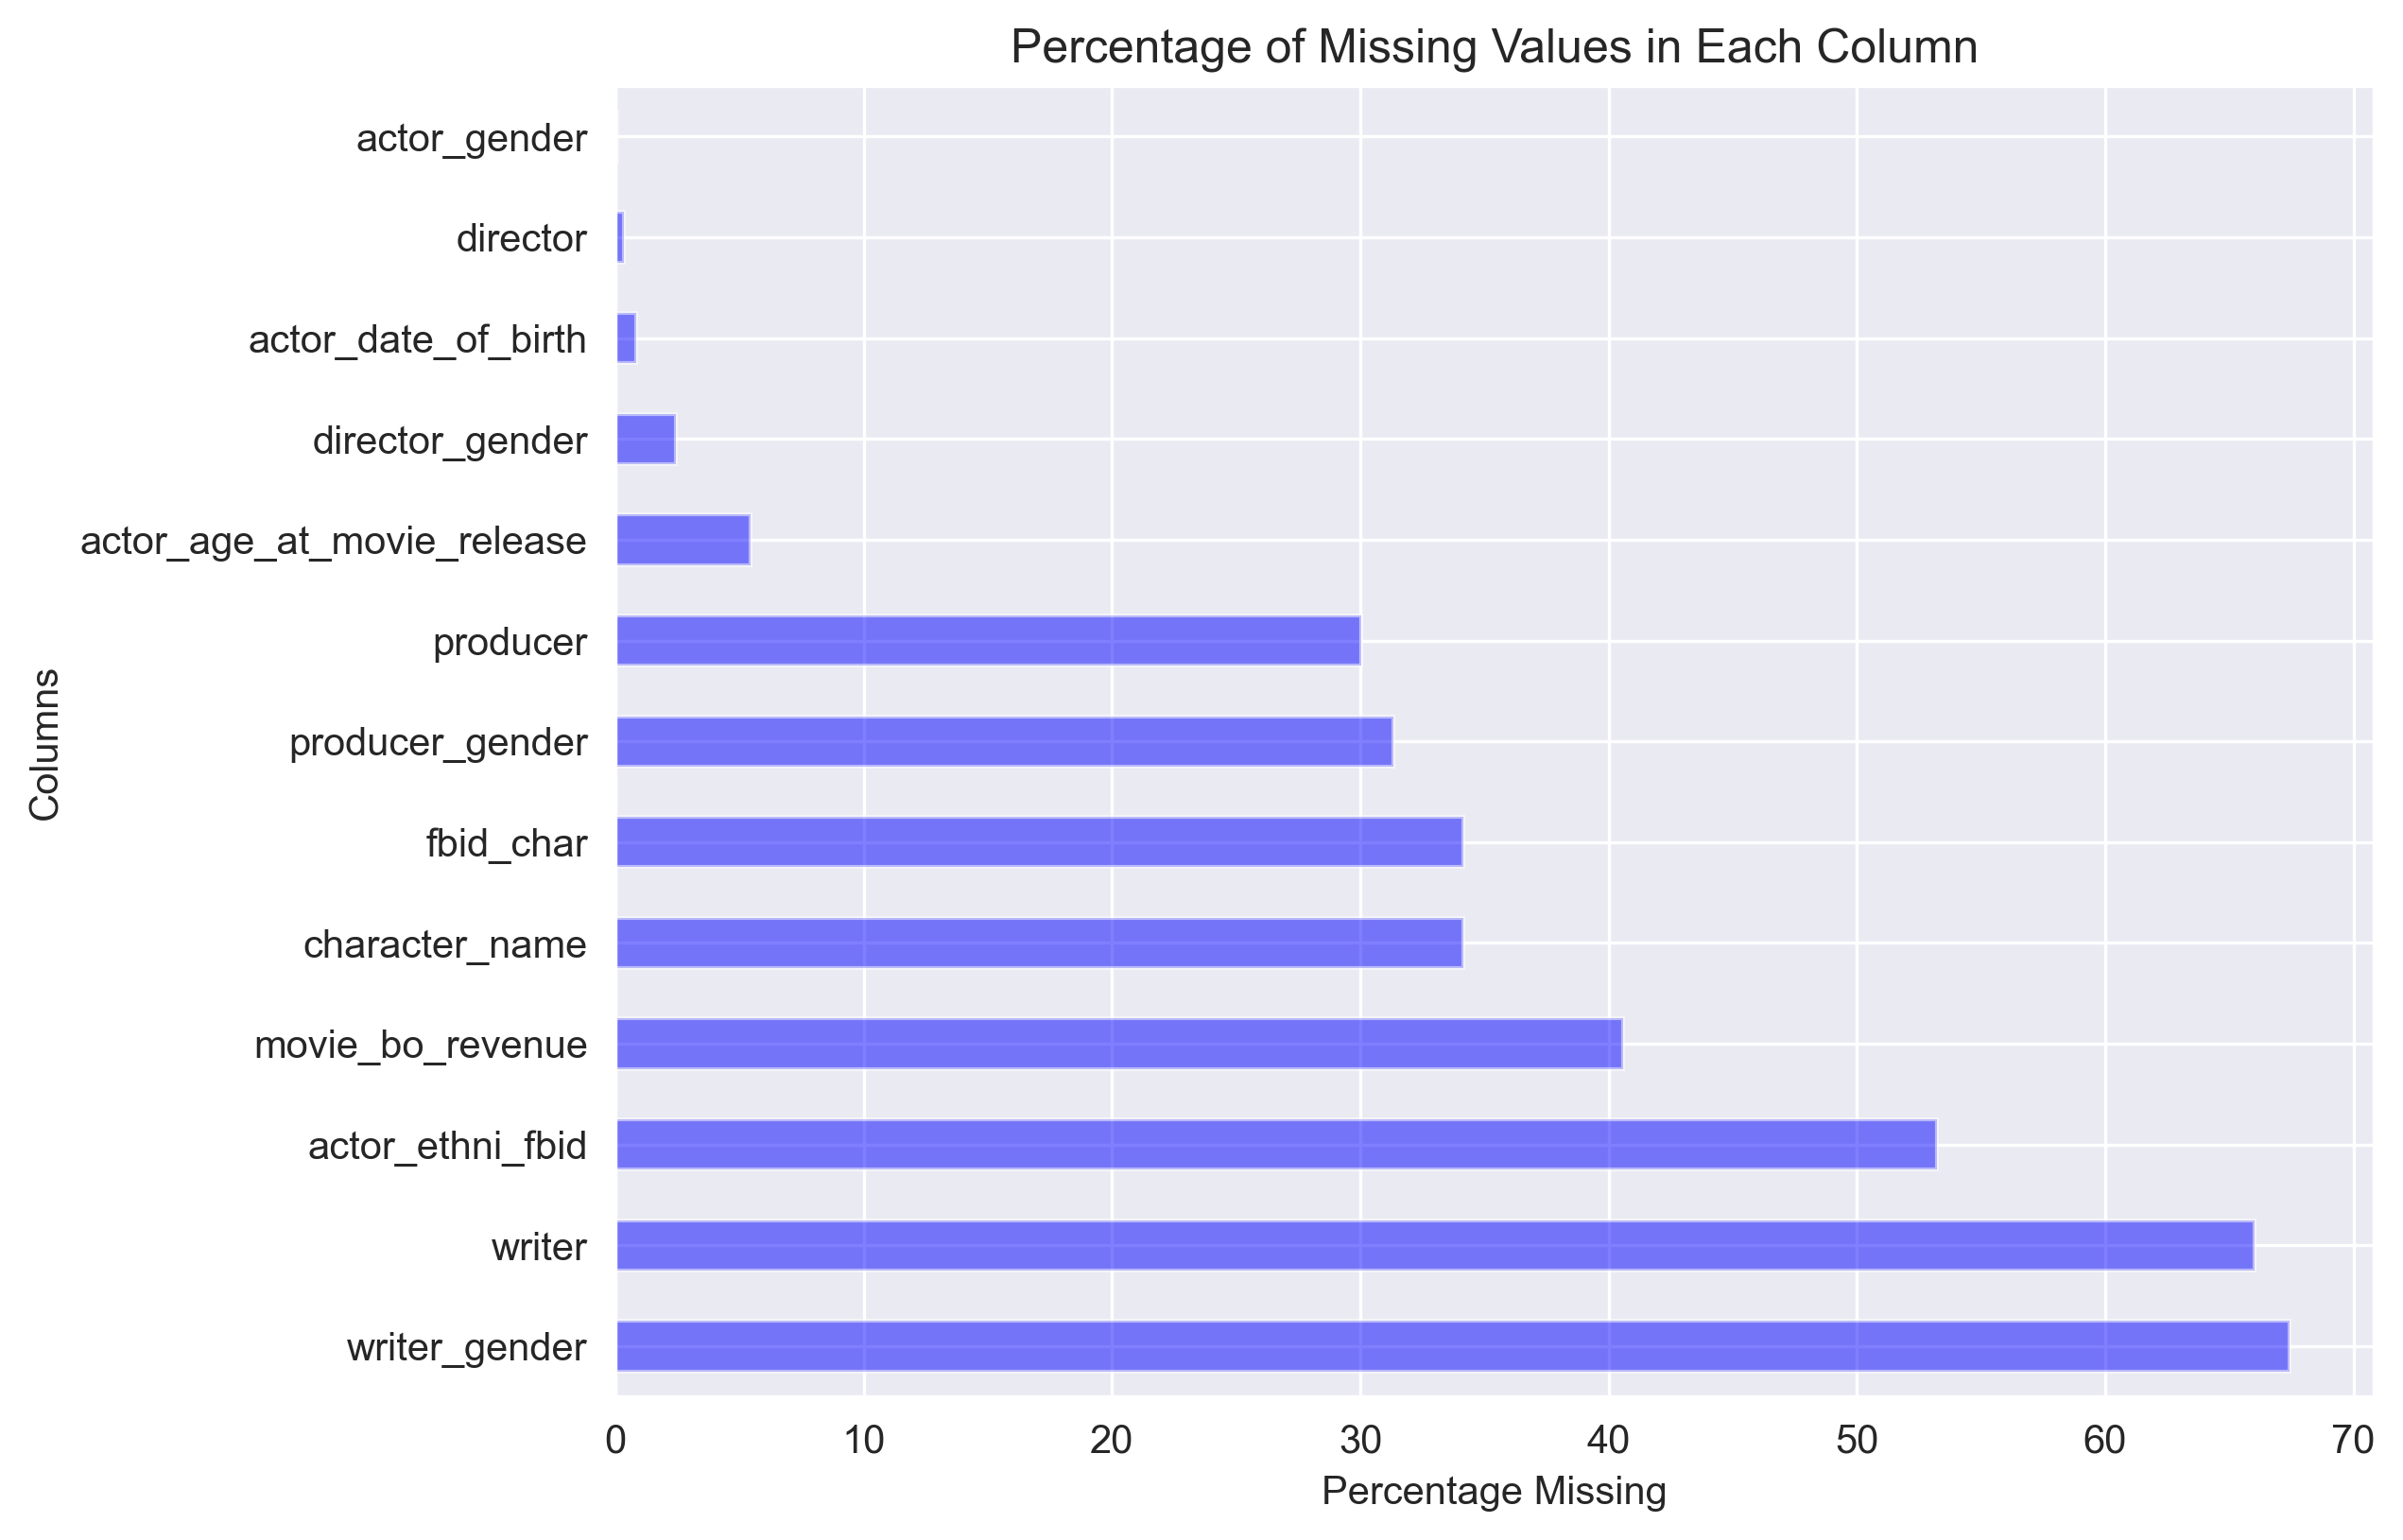

In [13]:
viz.visualize_missing_values(movies)

Based on the previous plot, it is evident that there are numerous missing values for the `writer` and `writer_gender` features. Given their limited usability due to this, it's necessary to remove them. Additionally, the `actor_ethni_fbid` feature, which would not have been utilized regardless, should also be dropped.

This correspond to dropping colums with more than 50% of missing values.

In [15]:
movies = cleaner.clean_missing_values_by_dropping(
    movies, to_drop=["writer", "writer_gender", "actor_ethni_fbid"]
)
display(movies.sample(2))

,actor_name,wikiID,freebaseID,movie_title,movie_release_date,movie_bo_revenue,movie_runtime,fbid_languages,fbid_countries,fbid_genres,...,summary,budget,popularity,vote_average,imdbid,id,director,director_gender,producer,producer_gender
157724,Kang Dong-won,29846796,/m/0fq2gls,Haunters,2010-11-10,13346235.0,114.0,[Korean Language],[South Korea],"[Thriller, Action]",...,Kyu-nam works at a run-down pawnshop. When Cho...,0,2.77211,6.2,1900891,68252,Marshall Neilan,M,NaN,NaN
1960,Kristen Wilson,6244632,/m/0fymw0,Crossover,2006-09-01,7009668.0,95.0,[English Language],[United States of America],"[Sports, Coming of age, Action, Drama, Teen]",...,Noah Cruise is a naturally talented basketbal...,5800000,0.906143,4.2,0473024,14351,Preston A. Whitmore II,M,Frank Mancuso Jr.,M


# 2. Data Analysis 
## 2.1. Global Analysis 
### Part 1. Analysis of inequalities  

In this section, we will examine the distribution of women in various sectors of the movie industry. To begin, let's visualize the distribution of men and women across three roles: actors, film directors, and producers.

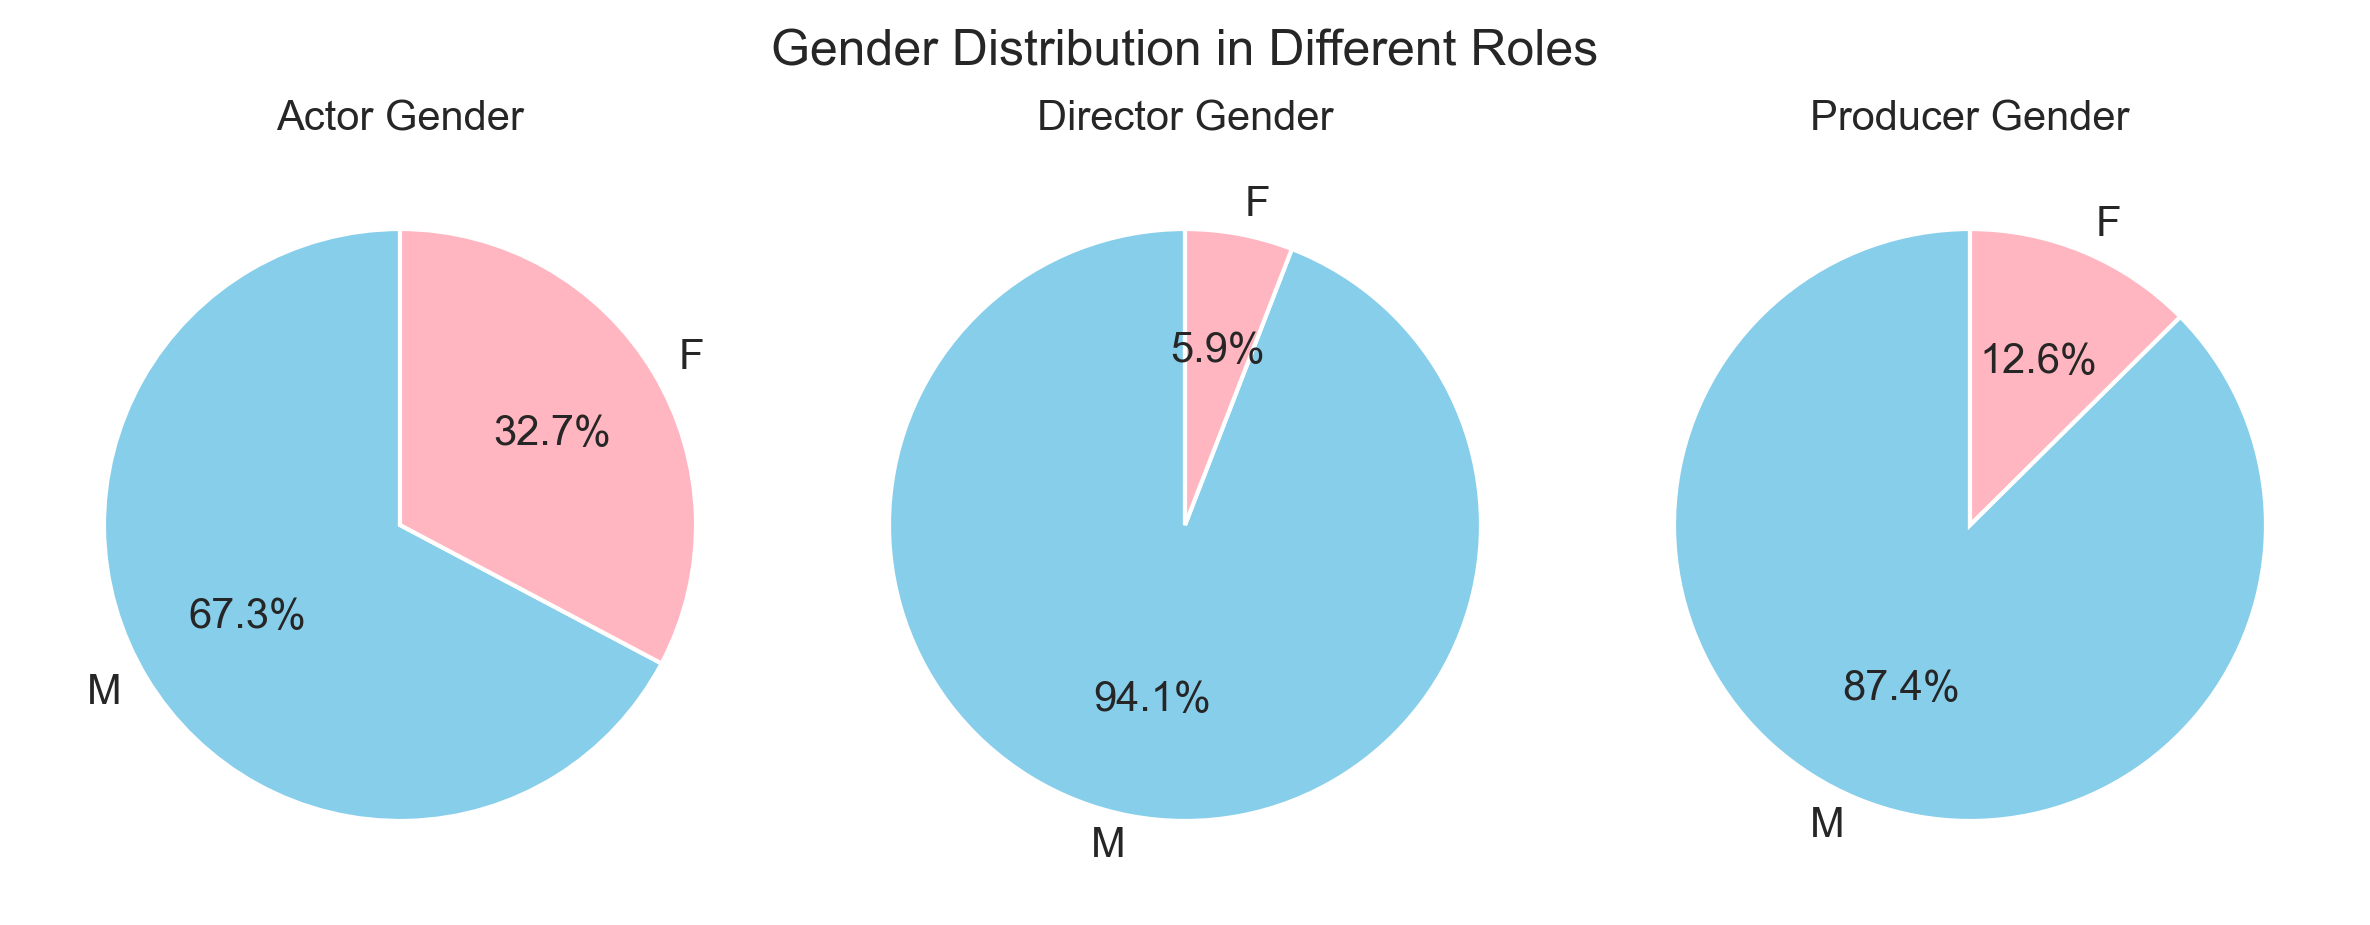

In [74]:
viz.visualize_gender_distribution(movies)

One can clearly see that women are underrepresented both in front of the camera and behind the scenes. Actually, they are much less represented behind the camera than in front of it. This is a first interesting observation.

### Part 2. Analysis of stereotypes in gender representation

In this section, we want to explore roles given to women and see it's stereotypes. 

In [69]:
roles = loader.load_roles()

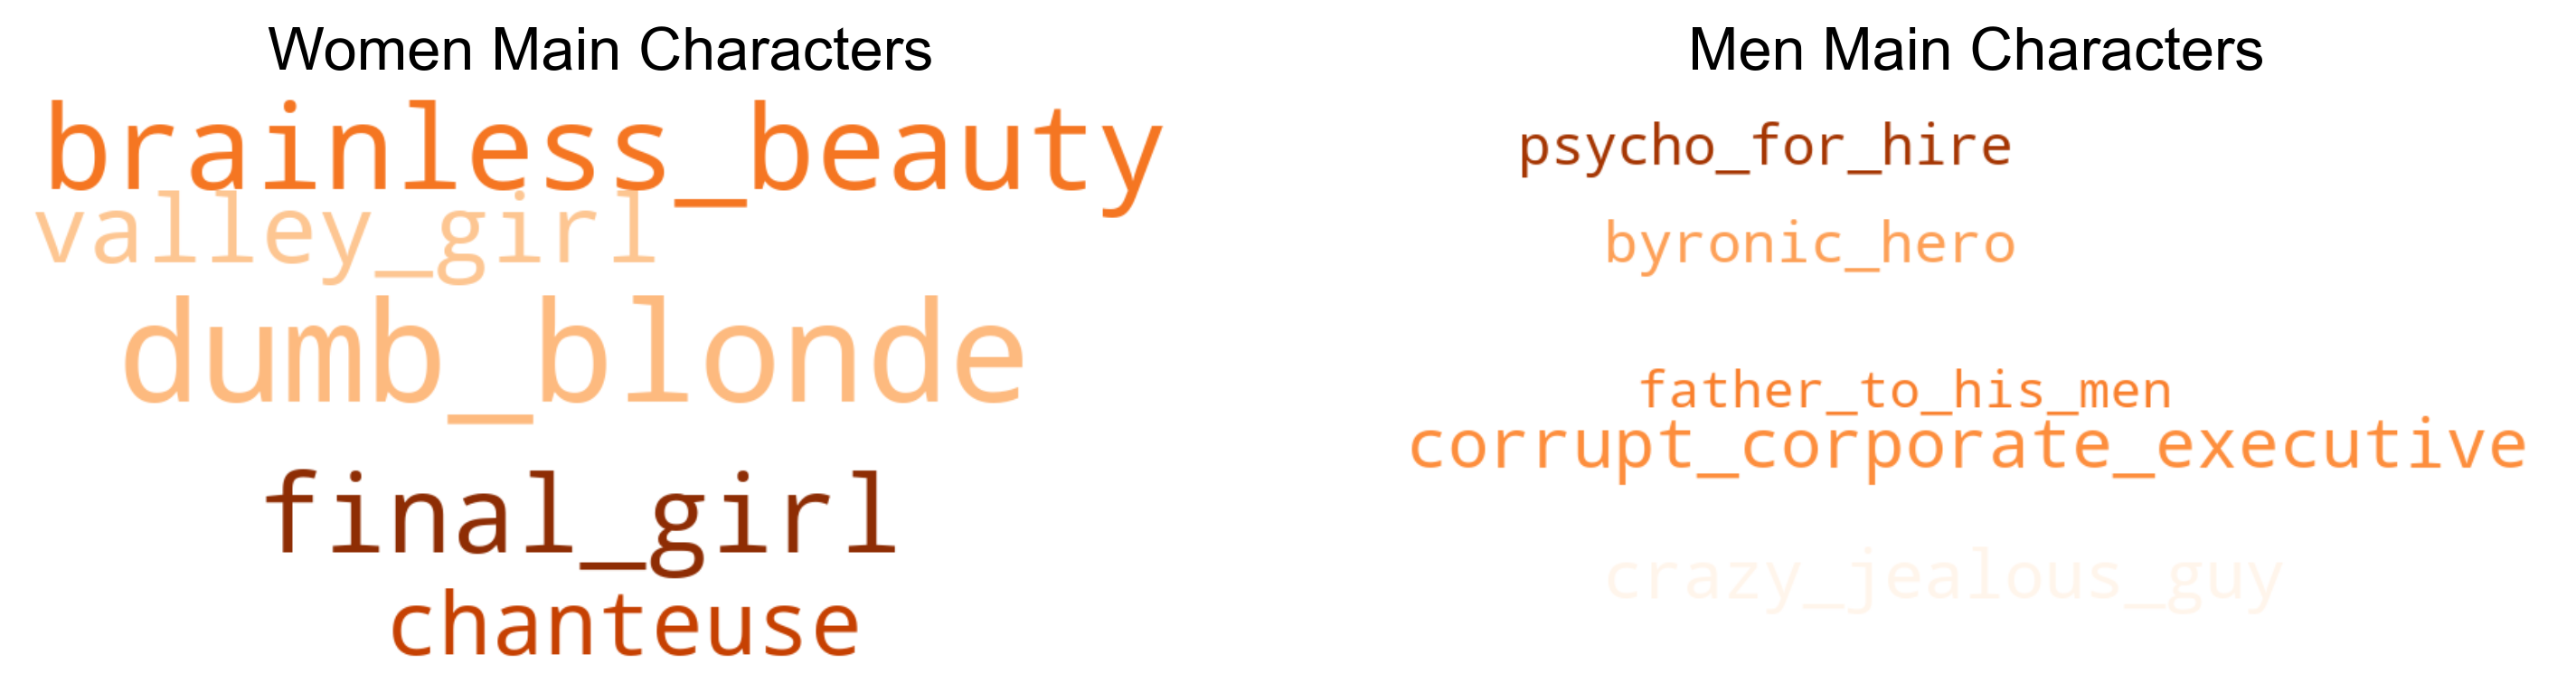

In [73]:
actor_with_role = movies.merge(chartypes, on=["movie_title", "fbid_char_actor_map"], how="inner").copy(deep=True)

viz.visualize_wordcloud_roles(actor_with_role)

The contrast in the terms used for men and women in this word cloud reflect common gender stereotypes in storytelling and media, where men are often associated with power and action, while women are often portrayed in relation to beauty and emotional roles.


### Part 3. Analysis of reception 
### Part 4. Across the world (Fine-Grained Analysis)


## 2.2. Bechdel Test 
## 2.3 NLP 
# 3. Conclusion